In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

I will use the GPU: Tesla P100-PCIE-16GB


In [3]:
updated_train=pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
updated_test=pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
updated_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

updated_train['text'] = updated_train['text'].apply(preprocess)
updated_test['text'] = updated_test['text'].apply(preprocess)
updated_train = updated_train[updated_train["text"]!='']

In [6]:
updated_train = updated_train[["text","target"]]
updated_train.head()

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,13000 people receive wildfires evacuation orde...,1
4,just got sent this photo from ruby alaska as s...,1


In [7]:
updated_train["target"].value_counts()

0    4314
1    3247
Name: target, dtype: int64

In [8]:
# Get the lists of lyrics and their labels.
texts = updated_train.text.values
labels = updated_train.target.values

In [9]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification,AdamW
import torch
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
model = ElectraForSequenceClassification.from_pretrained('google/electra-base-discriminator',num_labels=2)
model.cuda()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.d

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

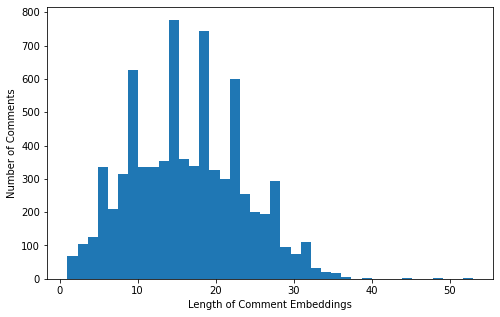

In [10]:
#to show length of embedding will be helpful to determine maximum length of comments and padding threshold
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
plot_sentence_embeddings_length(texts, tokenizer)

In [11]:
indices=tokenizer.batch_encode_plus(texts,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)

input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [12]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [14]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [16]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [17]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [18]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # `batch` contains three pytorch tensors: [0]: input ids ,[1]: attention masks,[2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients.
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Evaluate the model on this training batch.
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        loss = outputs[0]

        # Accumulate the training loss over all of the batches 
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0. to prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:12.
  Batch   100  of    189.    Elapsed: 0:00:23.
  Batch   150  of    189.    Elapsed: 0:00:34.

  Average training loss: 0.57
  Training epoch took: 0:00:43

======== Epoch 2 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:11.
  Batch   100  of    189.    Elapsed: 0:00:22.
  Batch   150  of    189.    Elapsed: 0:00:34.

  Average training loss: 0.42
  Training epoch took: 0:00:42

======== Epoch 3 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:11.
  Batch   100  of    189.    Elapsed: 0:00:22.
  Batch   150  of    189.    Elapsed: 0:00:34.

  Average training loss: 0.38
  Training epoch took: 0:00:42

======== Epoch 4 / 5 ========
Training...
  Batch    50  of    189.    Elapsed: 0:00:11.
  Batch   100  of    189.    Elapsed: 0:00:23.
  Batch   150  of    189.    Elapsed: 0:00:34.

  Average training loss: 0.35
  Training epoch took: 0:00:42

======== Epoch 

In [19]:
# Validation
print("")
print("Running Validation...")

t0 = time.time()
model.eval()

preds=[]
true=[]

# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
    
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():        

        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # Get the "logits" output by the model. The "logits" are the output values prior to applying an activation function like the softmax.
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    preds.append(logits)
    true.append(label_ids)
    # Calculate the accuracy for this batch.
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    # Accumulate the total accuracy.
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

# Report the final accuracy for this validation run.
print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("  Validation took: {:}".format(format_time(time.time() - t0)))


Running Validation...
  Accuracy: 0.82
  Validation took: 0:00:03


In [20]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in preds for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true for item in sublist]

In [21]:
from sklearn.metrics import classification_report
print(classification_report(flat_predictions,flat_true_labels))

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       940
           1       0.73      0.83      0.78       573

    accuracy                           0.82      1513
   macro avg       0.81      0.82      0.81      1513
weighted avg       0.83      0.82      0.82      1513



In [22]:
comments1 = updated_test.text.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)


# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  
  
  # Store predictions and true labels
  predictions.append(logits1)

flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

Predicting labels for 3,263 test sentences...


In [24]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submit=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':flat_predictions})
#submit.to_csv('submission.csv',index=False)

In [25]:
submit.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [26]:
df_leak = pd.read_csv('/kaggle/input/disasters-on-social-media/socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[['choose_one', 'text']]

# Creating target and id
df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak['id'] = df_leak.index.astype(np.int16)
df_leak.drop(columns=['choose_one', 'text'], inplace=True)

# Merging target to test set
updated_test = updated_test.merge(df_leak, on=['id'], how='left')

print('Leaked Data Set Shape = {}'.format(df_leak.shape))
print('Leaked Data Set Memory Usage = {:.2f} MB'.format(df_leak.memory_usage().sum() / 1024**2))

perfect_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
perfect_submission['target'] = updated_test['target'].values
perfect_submission.to_csv('submission.csv',index=False)
perfect_submission.describe()

Leaked Data Set Shape = (10876, 2)
Leaked Data Set Memory Usage = 0.09 MB


,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.429666
std,3146.427221,0.495104
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


**Exploratory Data Analysis**

In [27]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize 


nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [20,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [28]:
train = pd.read_csv("../input/nlp-getting-started/train.csv")
test = pd.read_csv("../input/nlp-getting-started/test.csv")

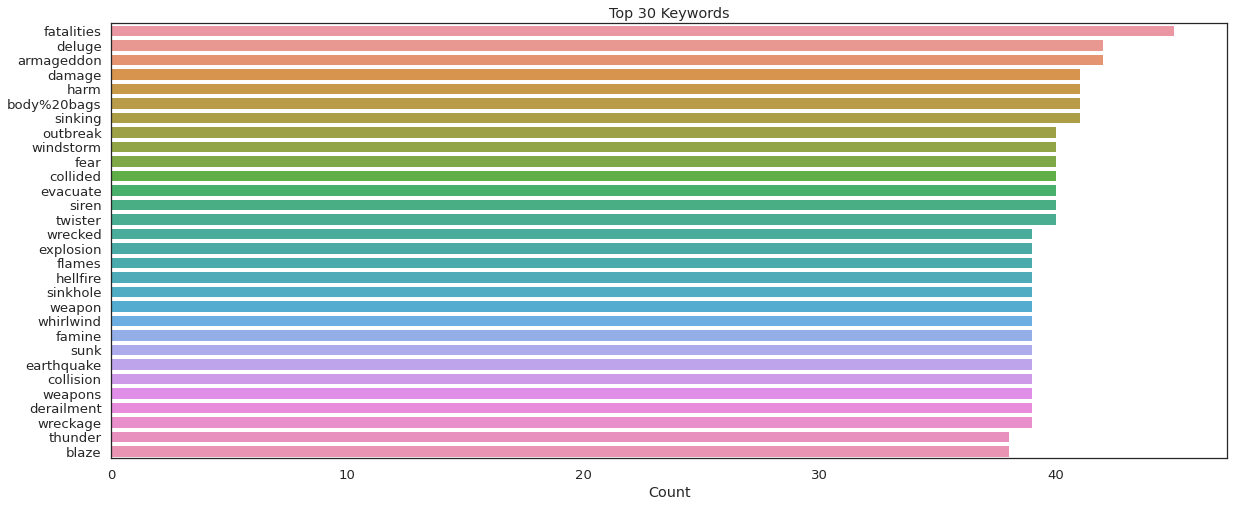

In [29]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

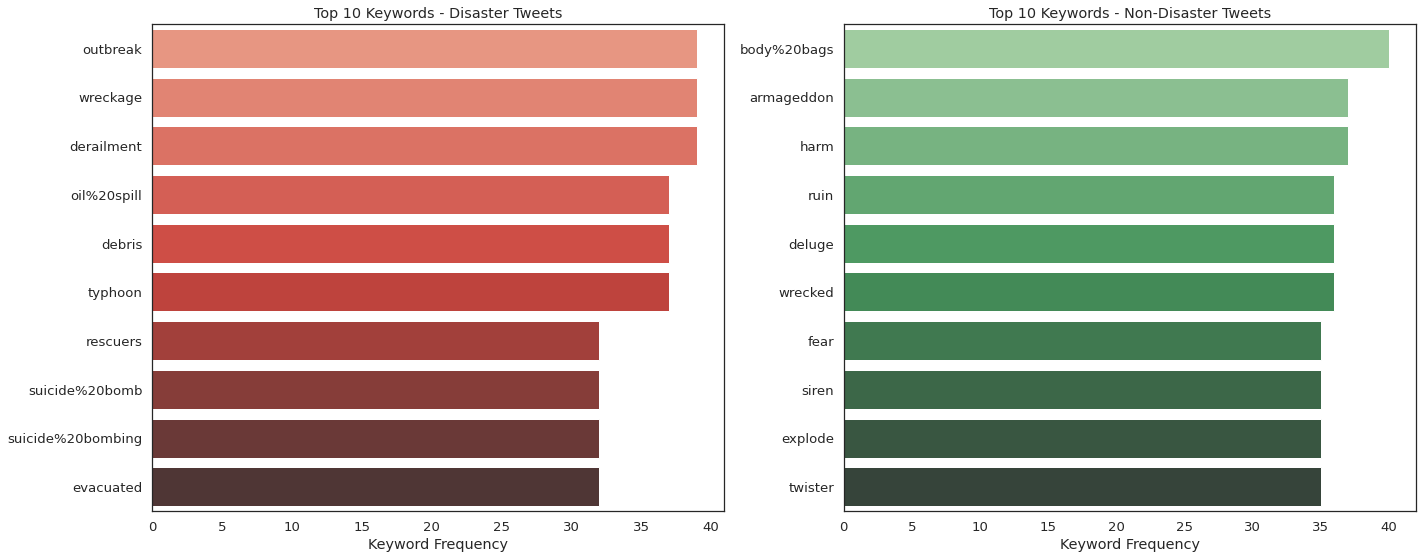

In [30]:
disaster_keywords = train.loc[train["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train.loc[train["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:10].index, x=disaster_keywords[0:10], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:10].index, x=nondisaster_keywords[0:10], orient='h', ax=ax[1], palette="Greens_d")
ax[0].set_title("Top 10 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 10 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

In [31]:
tsunami_tweets = train[(train["keyword"].fillna("").str.contains("tsunami")) & (train["target"] == 0)]
print("An example tweet:\n", tsunami_tweets.iloc[20, 3])
tsunami_tweets.head()

An example tweet:
 @GreenLacey GodsLove &amp; #thankU my sister for RT of NEW VIDEO http://t.co/cybKsXHF7d The Coming Apocalyptic US Earthquake &amp; Tsunami


,id,keyword,location,text,target
6943,9958,tsunami,NaN,I feel so lucky rn,0
6946,9963,tsunami,in the Word of God,@freefromwolves GodsLove &amp; #thankU brother...,0
6947,9965,tsunami,"Washington, DC",I'm at Baan Thai / Tsunami Sushi in Washington...,0
6948,9967,tsunami,NaN,she keep it wet like tsunami.,0
6949,9971,tsunami,"Louavul, KY",#BBShelli seems pretty sure she's the one that...,0


In [32]:
def keyword_disaster_probabilities(x):
    tweets_w_keyword = np.sum(train["keyword"].fillna("").str.contains(x))
    tweets_w_keyword_disaster = np.sum(train["keyword"].fillna("").str.contains(x) & train["target"] == 1)
    return tweets_w_keyword_disaster / tweets_w_keyword

keywords_vc["Disaster_Probability"] = keywords_vc.index.map(keyword_disaster_probabilities)
keywords_vc.sort_values(by="Disaster_Probability", ascending=False).head(10)

,Count,Disaster_Probability
derailment,39,1.000000
debris,37,1.000000
wreckage,39,1.000000
outbreak,40,0.975000
oil%20spill,38,0.973684
typhoon,38,0.973684
suicide%20bombing,33,0.969697
suicide%20bomber,31,0.967742
bombing,29,0.951613
suicide%20bomb,35,0.949495


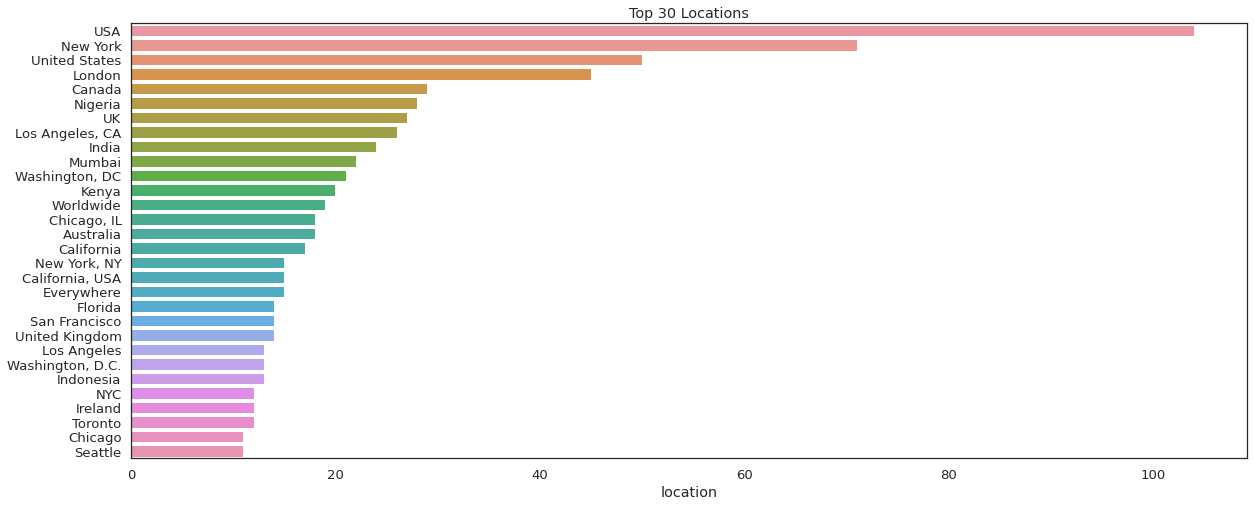

In [33]:
locations_vc = train["location"].value_counts()
sns.barplot(y=locations_vc[0:30].index, x=locations_vc[0:30], orient='h')
plt.title("Top 30 Locations")
plt.show()

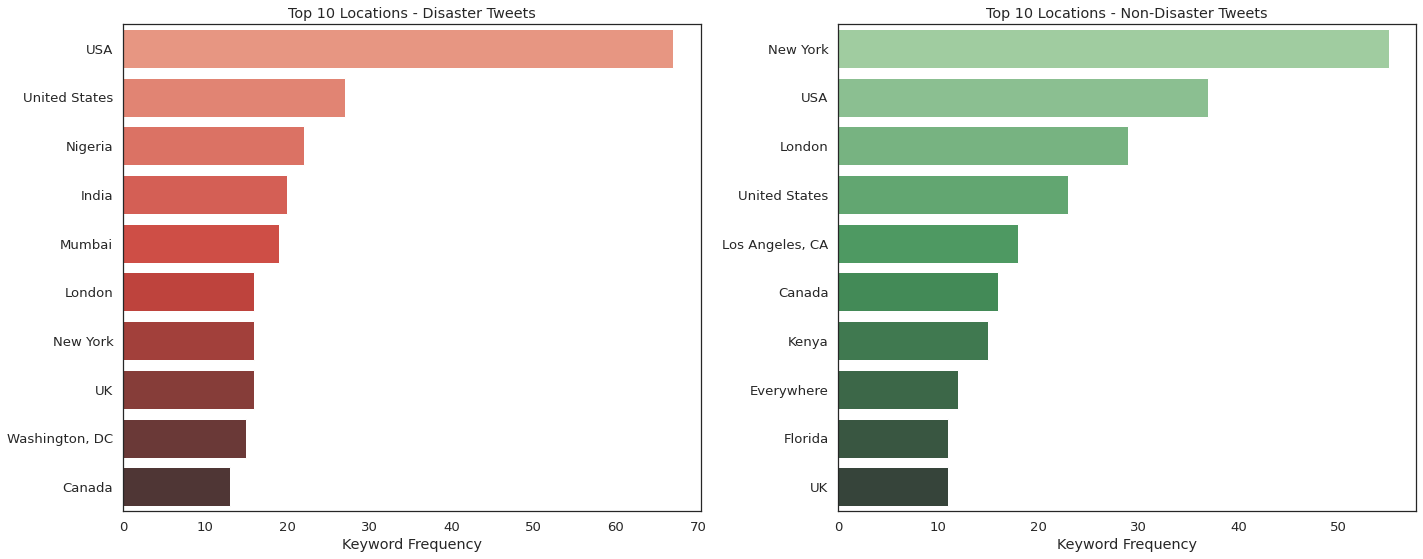

In [34]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:10].index, x=disaster_locations[0:10], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:10].index, x=nondisaster_locations[0:10], orient='h', ax=ax[1], palette="Greens_d")
ax[0].set_title("Top 10 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 10 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

Not Disaster: 57.03%, Disaster: 42.97%


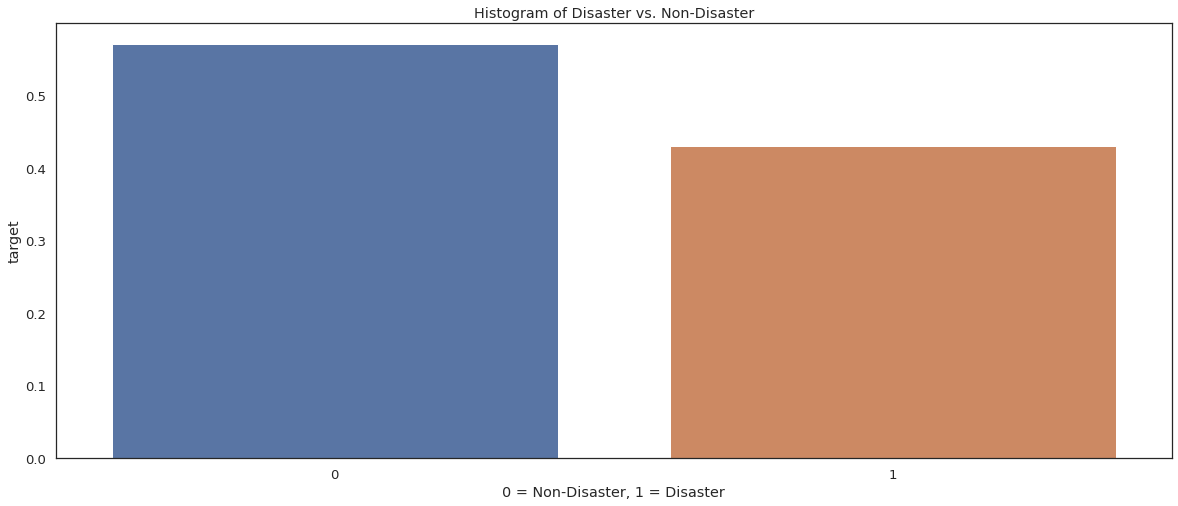

In [35]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()